# This file is used for neural field simulation for TI stimulation 

In [1]:
from tvb.simulator.lab import *

In [2]:
import time as tm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/root/capsule/code/util')
from utils_simulate import CorticalSurface_new, LocalConnectivity_new, LaplaceKernel, SpatEpi, Heaviside
from utils_simulate import zero_columns, zero_rows

In [4]:
from utils_integrator import HeunDeterministicAdapted
from utils_patterns import StimuliSurface_new, TI_SpatioTemporalPattern
from utils_model4 import SpatEpiStim

In [5]:
local_con_scaling = 0.4#0.8
global_con_scaling = 0.1

In [6]:
subject_dir = f'/data/ana/vep/'
data_dir = f'{subject_dir}/tvb/'

In [7]:
# Initialise a Connectivity
print("Setup long range connectivity")
con = connectivity.Connectivity.from_file(str(data_dir + 'connectivity.vep.zip'))
con.weights = np.log(con.weights+1)
con.weights /= con.weights.max()
con.speed = np.array([6])
con.configure()

Setup long range connectivity
2024-09-06 09:59:22,891 - WARNING - tvb.basic.readers - File 'average_orientations' not found in ZIP.
2024-09-06 09:59:22,892 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-09-06 09:59:22,892 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.


In [8]:
# Surface and local connectivity kernel
print("Setup local connectivity")
res = '_ico5'
surf = cortex.Cortex.from_file(source_file= str(data_dir + ("/Cortex_pial"+res+".zip")),
                                region_mapping_file=str(data_dir + ("/Cortex_region_map"+res+".txt")))
surf.region_mapping_data.connectivity = con
loc_conn = LocalConnectivity_new(equation=LaplaceKernel(), cutoff=10.0)
loc_conn.equation.parameters['b'] = 1
loc_conn.equation.parameters['amp'] = local_con_scaling
cort_surf = CorticalSurface_new.from_file(source_file=str(data_dir + ("/Cortex_pial"+res+".zip")))
cort_surf.configure()
loc_conn.surface = cort_surf

print("Configure cortical surface")
surf.local_connectivity = loc_conn
surf.configure()

Setup local connectivity
Configure cortical surface


In [9]:
# set corpus callosum/ medial wall vertices to 0 in local connectivity
csr_mat = surf.local_connectivity.matrix
csr_mat = zero_columns(csr_mat, np.where(surf.region_mapping == 0)[0])
csr_mat = zero_rows(csr_mat, np.where(surf.region_mapping == 0)[0])
csr_mat.eliminate_zeros()
surf.local_connectivity.matrix = csr_mat

In [10]:
# Neural mass model
k = 0.318
g11 = 0.5334
g22 = 1.0
epileptors = SpatEpiStim()#Spat7DEpi()
epileptors.variables_of_interest = ('u1', 'q1', 's', 'm')#('x1', 'x2', 'z', 'm')
epileptors.gamma11 = np.array([k*g11])
epileptors.gamma12 = np.array([k*0.1])
epileptors.gamma22 = np.array([k*g22])
epileptors.theta11 = np.array([-1.0])
epileptors.theta12 = np.array([-1.0])
epileptors.theta22 = np.array([-0.5])
epileptors.Iext   = np.array([3.1])
epileptors.Iext2   = np.array([0.45])
epileptors.tau2    = np.array([10.0])
epileptors.tt      = np.array([0.17])
# epileptors.r = np.array([0.0015])
# epileptors.r2 = np.array([0.0022])
epileptors.tau0 = np.array([715])
epileptors.tau3 = np.array([455])

n_nodes = surf.vertices.shape[0] + sum(np.invert(con.cortical)) # number of vertices + subcortical regions
epileptors.x0      = np.ones((n_nodes)) * (-2.5)
epileptors.threshold = np.ones((n_nodes)) * (10.0)

# new variables for 3D Epileptor:
epileptors.Istim  = np.ones((n_nodes)) * (0.)
# epileptors.n_stim = np.ones((n_nodes)) #* 0

# Create a regionmap as will be used in the simulator later, in order to set parameters for subcortical structures
_regmap  = np.r_[surf.region_mapping, con.unmapped_indices(surf.region_mapping)]

In [11]:
EZ = ['Left-F1-lateral-prefrontal']
PZ = []
for name in EZ:
    con_idx = np.where(con.region_labels == name)[0]
    rm_idx = np.where(_regmap == con_idx)
    epileptors.x0[rm_idx] = -2.3
    epileptors.threshold[rm_idx] = 1.8

for name in PZ:
    con_idx = np.where(con.region_labels == name)[0]
    rm_idx = np.where(_regmap == con_idx)
    epileptors.x0[rm_idx] = -2.1
    epileptors.threshold[rm_idx] = 4.5


In [12]:
ti_field_dir = "/data/EMF"
ti_field = np.load(f'{ti_field_dir}/TI_2_fields_norm_downsampled.npz')['ti_field'][:5000,:]

In [13]:
plt.figure()
for i in range(80):
    plt.plot(ti_field[:2000,i])
    plt.plot([1000], ti_field[:, i].max(), 'b.', markersize=10)
    plt.plot([1500], ti_field[:, i].min(), 'r.', markersize=10)
    # plt.plot(ti_field[:, i].max()-ti_field[:, i].min(), '.')
    # plt.vlines(20, ymin=0, ymax=0.4)
    plt.vlines(1500, ymin=0, ymax=0.4)
    plt.vlines(1000, ymin=0, ymax=0.4)
    # plt.plot((ti_field[:,i]-ti_field[:,i].min())/(ti_field[:,i].max()-ti_field[:,i].min()))
plt.show()

In [14]:
stim_weights = np.zeros(n_nodes)
stim_weights[:surf.vertices.shape[0]] = ti_field[1000, :] - ti_field[1500,:]
   
I = 0.3#1#1.3 # pulse intensity [mA]

# Define the stimulus
class vector1D(equations.DiscreteEquation):
    equation = equations.Final(default="emp")
eqn_t = vector1D()
# taking the normalized TI signal for one random vertex (here vertex of index 0)
ti_signal_normalized = (ti_field[:,0]-ti_field[:,0].min())/(ti_field[:,0].max()-ti_field[:,0].min())
# TODO shifting it such that we center it's average value to 0
ti_signal_centered = ti_signal_normalized - (ti_signal_normalized.max()+ti_signal_normalized.min())/2
ti_signal = np.concatenate((ti_signal_centered, ti_signal_centered))#, ti_signal_centered))
                            # ti_signal_centered, ti_signal_centered))
# ti_signal = np.concatenate((ti_signal_normalized, ti_signal_normalized,
#                             ti_signal_normalized, ti_signal_normalized,
#                             ti_signal_normalized))

# stimulus parameters
onset = 1000  # [ms]
dt = 0.2
stim_length = ti_signal.size * dt  # [ms]
simulation_length = onset + stim_length + 6000   #3500 [ms]
print(f'Simulation length {simulation_length} ms.')
stimulus_ts = np.hstack((np.zeros(int(onset / dt)), ti_signal*I, np.zeros(int(np.ceil((simulation_length - stim_length - onset) / dt)))))
eqn_t.parameters['emp'] = np.copy(stimulus_ts)

stimulus = StimuliSurface_new(temporal=eqn_t, weight = stim_weights)
stimulus.configure_time(np.arange(0., simulation_length/dt, 1))
stimulus.configure_space()

Simulation length 9000.0 ms.


In [15]:
# Integrator
heunint = HeunDeterministicAdapted(dt=dt)

# Monitors
mons = [monitors.TemporalAverage(period=10.),
        monitors.SpatialAverage(period=10., spatial_mask = _regmap)]

# Global connectivity
# coupl = coupling.Difference(a=np.array([global_con_scaling]))
coupl = Heaviside(a=np.array([global_con_scaling]), theta=np.array([-1]))

# Initial conditions
ic = [-1.6242601e+00,  -16.69344913e+00,   4.1, -1.11181819e+00,  -9.56105974e-20,  -4.38727802e-01,  0]
ic_full = np.repeat(ic, n_nodes).reshape((len(ic), n_nodes, 1))


In [16]:
# Simulator
sim = simulator.Simulator(model=epileptors,
                        stimulus=stimulus,
                        connectivity=con,
                        coupling=coupl,
                        integrator=heunint,
                        monitors=mons,
                        surface=surf)
sim.configure()
sim.current_state = ic_full

## Here you can adjust the simulation length, if it's taking too long.
## For example: setting simulation_length =  1200 will take about 2.4 mins to run, but this might be too short to showcase the interesting scenario.

In [22]:
# Run
print("Run Simulation !")
tic = tm.time()

results = sim.run(simulation_length=simulation_length)
print(f"Simulation length : {(tm.time()-tic)/60.} min.")

# Save results
(t, data_tavg), (t, data_savg) = results




Run Simulation !
2024-09-06 10:16:34,580 - WARNING - utils_integrator - random_state supplied for non-stochastic integration
Simulation length : 2.4681195537249248 min.


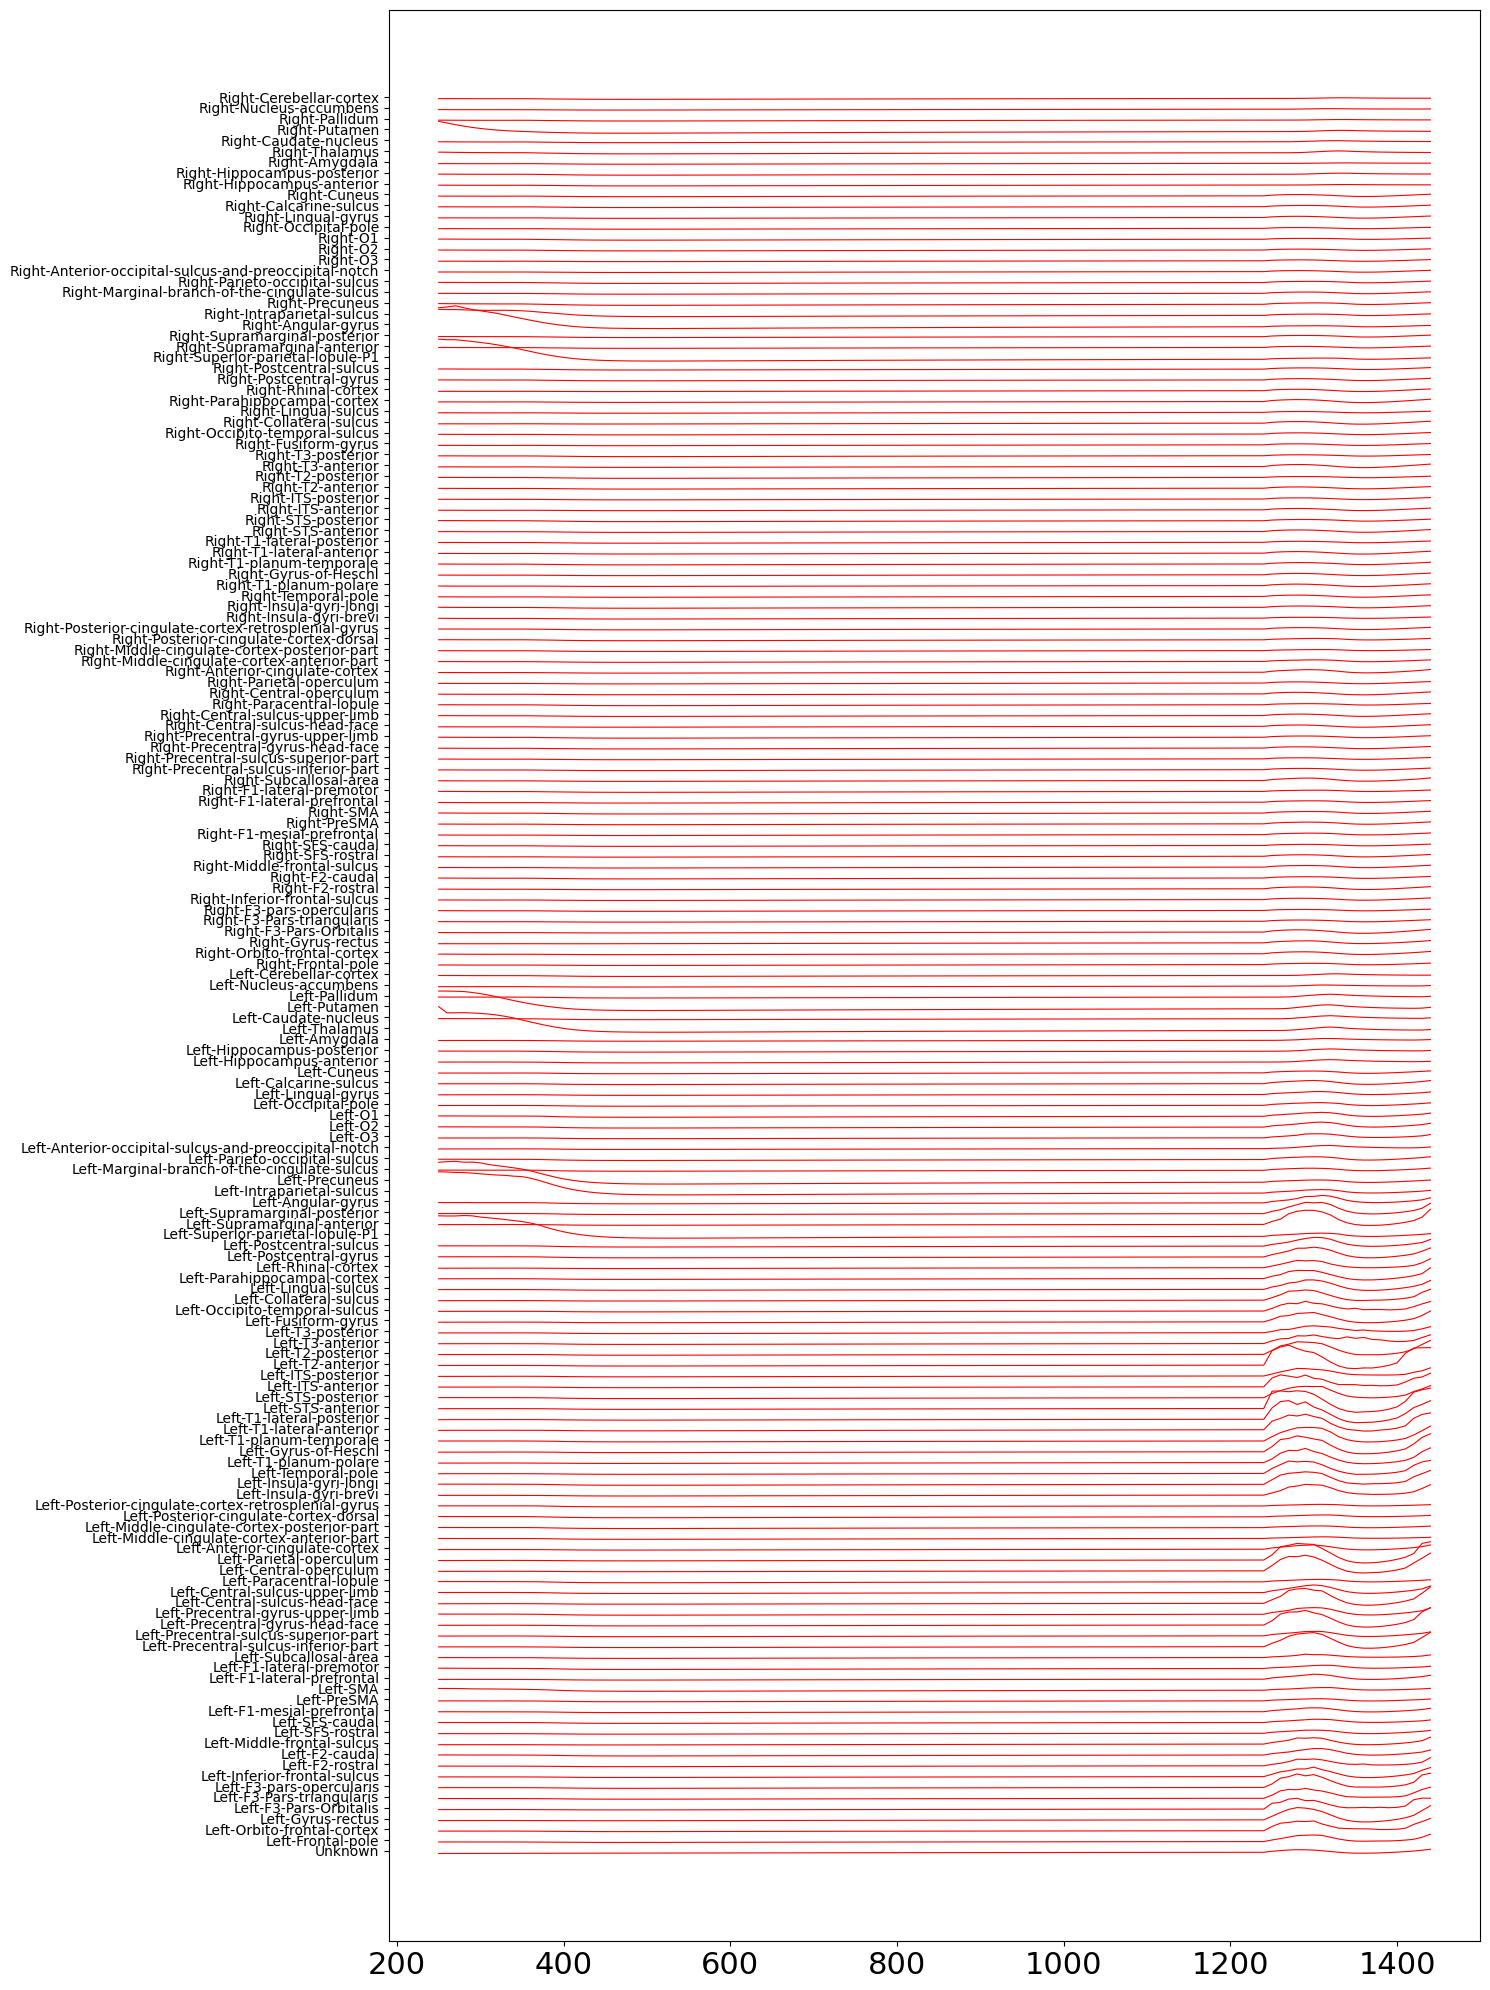

In [23]:
%matplotlib inline 
plot_data = True
if plot_data :
    # plot data
    roi = con.region_labels
    srcSig = data_savg[:, 0, :, 0]-data_savg[:, 1, :, 0]
    # srcSig_normal = srcSig/np.ptp(srcSig)

    # Plot raw time series
    fig = plt.figure(tight_layout=True, figsize=(15, 20))
    plt.plot(t, srcSig + np.r_[:len(roi)]+0.5, 'r', linewidth=0.8)
    plt.yticks(np.arange(len(roi)), roi, fontsize=10)

    plt.xticks(fontsize=22)

In [24]:
save_res = False
if save_res :
    # saving sensor data and source data
    save_sim_data = f'/results/'

    # save the generated data on the source level
    end = 750 # to crop the simulated time series before their end
    print(f'Saving simulated_source_data_glob_scal_{global_con_scaling}_loc_scal_{local_con_scaling}_I_{I}_7D')
    np.savez(f'{save_sim_data}/simulated_source_data_glob_scal_{global_con_scaling}_loc_scal_{local_con_scaling}_I_{I}_7D_LeftT1lateralanterior',
             time_steps=t[:end], tavg=data_tavg[:end, :,:,:], savg=data_savg[:end, :,:,:], I=I)
    np.savez(f'{save_sim_data}/simulated_source_data_glob_scal_{global_con_scaling}_loc_scal_{local_con_scaling}__7D_LeftT1lateralanterior_stisp', stim_weights=stimulus.spatial_pattern)
